# Advanced and Uncommon HARK Concepts

The "Gentle Introduction to HARK" and other notebooks *mostly* focused on the most important features that a new user would want to be familiar with. But HARK has a *lot* more options and deeper structure, and this notebook describes some of those "advanced" topics.

## Measuring Up: Distance in HARK

In heterogeneous agents macroeconomics, we are often interested in infinite horizon models. Such models are usually solved by "finite horizon approximation": iteratively solving backward one period at a time until consecutive solutions are sufficiently close together that we conclude the process has converged. When using Bellman value functions, this logic relies on the fact that the Bellman operator is a contraction mapping.

But what does it mean to be "sufficiently close"? What are we even comparing when we talk about the "distance" between two candidate solutions? It depends on the context, and so HARK has a system for easily identifying "what matters" when calculating the distance between two abstract objects.

Particularly, all classes in HARK that could reasonably be part of the representation of a model solution inherit from the superclass `HARK.metric.MetricObject`. Essentially all this class does is provide a "universal distance metric" with simple customization.

The *only* think that a subclass of `MetricObject` needs to specify is a class attribute called `distance_criteria`, which must be a list of strings. Each element of `distance_criteria` names an attribute of that class that should be compared if HARK is ever asked to compare two instances of that class.

HARK's universal distance metric is nothing more than a "recursive supremum norm". That is, it returns the *highest* value among element-wise distances. Its logic to compare $A$ and $B$ is straightforward and obvious:

- if $A$ and $B$ are both numbers, their distance is the absolute value of their difference
- if $A$ and $B$ are both lists, then:
  - if the lists have the same length, their distance is the maximum distance between corresponding elements
  - otherwise, the distance is the difference in their lengths
- if $A$ and $B$ are both `numpy.array`, then:
  - if the arrays have the same shape, then the distance is the absolute value of the maximum difference between corresponding elements
  - otherwise, the distance is the difference in their sizes (total number of elements)
  - **NB:** this is a bug that will be fixed
- if $A$ and $B$ are both dictionaries, then:
  - if they have the same keys, their distance is the maximum distance among their entries
  - otherwise, their distance is 1000, a large number
  - **NB:** this will be improved soon to look for a `distance_criteria` key
- if $A$ and $B$ are objects of the same class, and neither is a lambda function, then their distance is given by their `distance` method
- otherwise, the distance is 1000 because the objects cannot be meaningfully compared

As long as you are coding with `MetricObject` subclasses (like the interpolators in `HARK.interpolation`) and standard numeric Python objects, the distance metric will always succeed in comparing objects.

Note that comparing "incomparable" objects, like arrays of different shapes, will return a somewhat arbitrary "large" number (not near zero). This is because the sole purpose of measuring "distance" in HARK is to evaluate whether two solutions are sufficiently close. The tolerance level for such operations is usually on the order of $10^{-4}$ to $10^{-8}$, not $10$ or $1000$. That is, those "error code distances" mostly serve to ensure that a convergence criteria will *definitely* not be met when the comparitors are incomparable.

The tolerance for convergence is stored in the `tolerance` attribute of `AgentType` instances. It has a default of $10^{-6}$ but can be freely changed.

HARK only compares solutions from *consecutive* iterations when solving an infinite horizon model. In the future, we might add extended options to (say) compare a new solution to the one $N$ periods prior.

## Uncommon Options When Solving Models

The `solve()` method is usually called without any arguments, but there are a few options you can specify.

### Tell Me More, Tell Me More: `verbose`

First, passing `verbose=True` (or just `True`, because it is the first argument) when solving an infinite horizon model (`cycles=0`) will print solution progress to screen. This can be useful when developing a new model, if you want to know how long iterations take and how the solver is doing with respect to convergence.

In [1]:
from HARK.ConsumptionSaving.ConsIndShockModel import IndShockConsumerType

In [2]:
VerboseType = IndShockConsumerType(cycles=0)
VerboseType.solve(True)

Finished cycle #1 in 0.0 seconds, solution distance = 100.0
Finished cycle #2 in 0.0020003318786621094 seconds, solution distance = 10.088015890333441
Finished cycle #3 in 0.0010004043579101562 seconds, solution distance = 3.3534114736589693
Finished cycle #4 in 0.0009999275207519531 seconds, solution distance = 1.6699529613894297
Finished cycle #5 in 0.0010001659393310547 seconds, solution distance = 0.9967360674688521
Finished cycle #6 in 0.0010006427764892578 seconds, solution distance = 0.6602619046109499
Finished cycle #7 in 0.0009999275207519531 seconds, solution distance = 0.46809484231437626
Finished cycle #8 in 0.0009999275207519531 seconds, solution distance = 0.34807706501006663
Finished cycle #9 in 0.0010008811950683594 seconds, solution distance = 0.2681341538834978
Finished cycle #10 in 0.0010006427764892578 seconds, solution distance = 0.21223248168627507
Finished cycle #11 in 0.0010006427764892578 seconds, solution distance = 0.17162798586899441
Finished cycle #12 in 0.

Notice that the solver terminated as soon as the distance went below $10^{-6}$, the default value for `tolerance`.

### Turning Off `pre_solve` and `post_solve`

When `solve()` is invoked, the `AgentType` instance usually runs their `pre_solve()` method before jumping into the main solver loop over periods. In some situations, the user might want to *skip* the call to `pre_solve()`-- maybe it would undo some unusual work that the user wants in place. To do so, simply pass `presolve=False` in the call to `solve()`.

Likewise, *after* the solution loop has completed its work, just before exiting the call to `solve()`, HARK runs the `post_solve()` method for that `AgentType` subclass. In the unusual situation in which a user does *not* want that method run, just pass `postsolve=False` to `solve()`.

### Take It From the Middle: `from_solution` and `from_t`

HARK's default behavior is to solve all model periods, starting from `solution_terminal` and working back to the very first period. A user can override this with two interrelated options.

In case of some *custom* terminal solution (or continuation solution), the solution object can be passed in the `from_solution` argument. One use case for this is solving an infinite horizon model by starting from the solution to a "nearby" model, rather than from the proper terminal period.

Likewise, the `from_t` optional argument can be used to indicate which time index to *actually* start the solver from. This option is *only* compatible with `cycles=1`. In conjunction with `from_solution`, this can be used to (say) impose some terminal solution in the *middle* of the life-cycle, and only solve the problem from that point backward. That terminal solution *might* be the first period of some *other* model for a "later phase" of life.

If you pass an argument for `from_t` but not `from_solution`, then HARK will use `solution_terminal` as the succeeding solution when trying to solve the one-period problem at time index `from_t`.

## Utility Functions

Utility functions and related objects can be imported from `HARK.rewards`. These functions used to be in `HARK.utilities`, but we decided that it was too confusing to have both "utility functions" and "utility tools" in the same file.

Almost all consumption-saving models in HARK use constant absolute risk aversion (CRRA) utility functions over consumption. There are two main ways to use CRRA utility from `HARK.rewards`.

### In-Line Utility Functions

First, there are individual functions like `CRRAutility` and `CRRAutilityP` that take in a (possibly vector-valued) consumption argument and a CRRA coefficient. They do exactly what you'd expect, and are programmed to correctly handle $\rho=1$ being log utility.

In most circumstances, it's convenient to locally define the (marginal) utility function for the currently relevant value of $\rho$.

In [13]:
from HARK.rewards import CRRAutility, CRRAutilityP, UtilityFuncCRRA
import matplotlib.pyplot as plt
from HARK.utilities import plot_funcs

In [14]:
rho = 2.5  # maybe this parameter was passed from elsewhere
u = lambda x: CRRAutility(x, rho)
uP = lambda x: CRRAutilityP(x, rho)

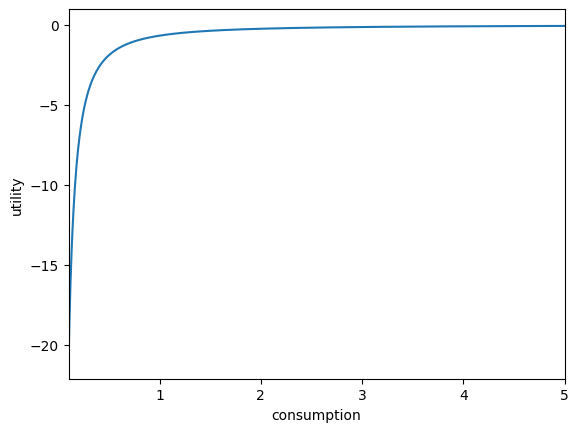

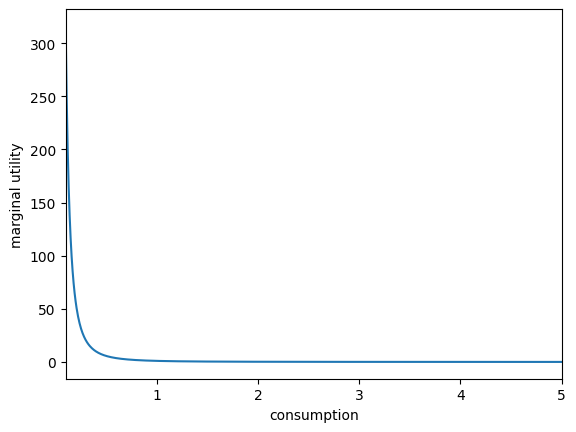

In [15]:
plt.xlabel("consumption")
plt.ylabel("utility")
plot_funcs(u, 0.1, 5.0)
plt.xlabel("consumption")
plt.ylabel("marginal utility")
plot_funcs(uP, 0.1, 5)

As a notational convention, HARK uses a capital `P` to denote "prime", and `_inv` for "inverse". `HARK.rewards` defines several layers of derivative and inverses for CRRA utility:

- `CRRAutility` : utility function
- `CRRAutilityP` : marginal utility function
- `CRRAutilityPP` : marginal marginal utility function
- `CRRAutilityPPP` : marginal marginal marginal utility function
- `CRRAutilityPPPP` : marginal marginal marginal marginal utility function
- `CRRAutility_inv` : inverse utility function
- `CRRAutilityP_inv` : inverse marginal utility function
- `CRRAutility_invP` : marginal inverse utility function
- `CRRAutilityP_invP` : marginal inverse marginal utility function

### Utility Function Structure

The second way to use CRRA utility is to simply import the class `UtilityFuncCRRA` and instantiate it with a single argument for $\rho$. This object then represents the utility function and *all* of its derivatives and inverses. Let's see an example.

In [10]:
U = UtilityFuncCRRA(2.0)  # CRRA utility function with rho=2

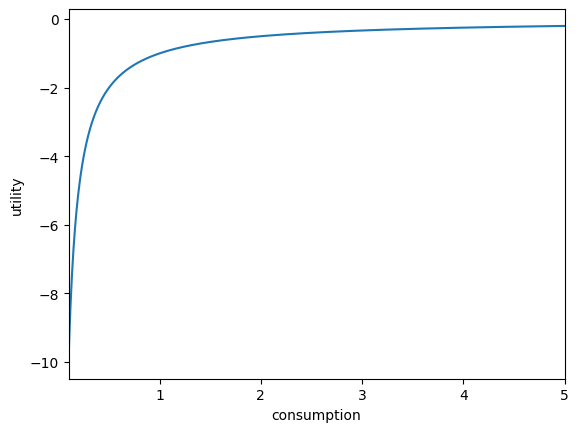

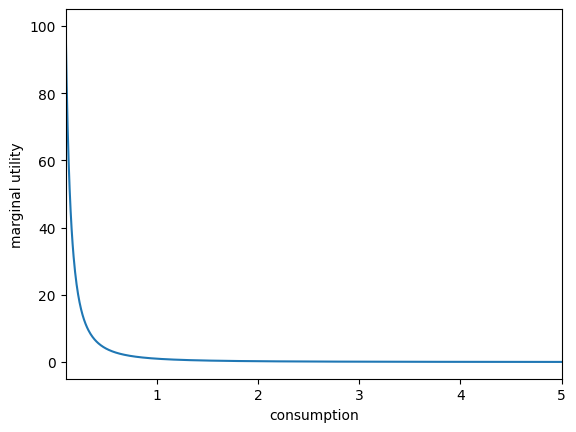

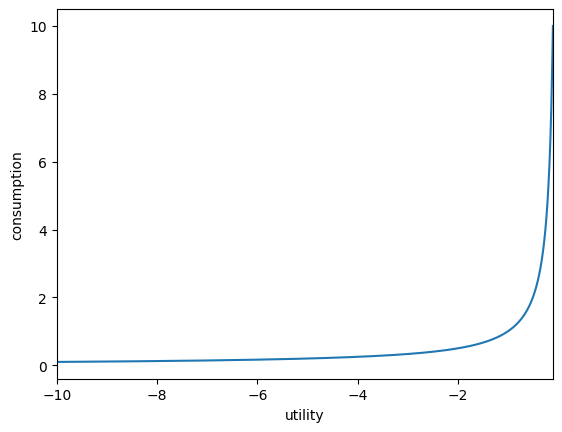

In [18]:
plt.xlabel("consumption")
plt.ylabel("utility")
plot_funcs(U, 0.1, 5.0)  # treat it like a function
plt.xlabel("consumption")
plt.ylabel("marginal utility")
plot_funcs(U.derivative, 0.1, 5)  # use its derivative method for marginal utility
plt.xlabel("utility")
plt.ylabel("consumption")
plot_funcs(U.inverse, -10.0, -0.1)  # use its inverse method

The `derivative` method accepts a second optional argument of `order` with a default of 1, indicating the order of the derivative (first to fourth order).

The `inverse` method also accepts an `order` argument as an ordered pair `(0,0)` to `(1,1)`. For a simple mnemonic, `order` refers to the number of `P`s in the function `CRRAutility[#1]_inv[#2]`. The default is `(0,0)`, which is just the inverse of utility.

### Other Utility Functions in `HARK.rewards`

Write this subsection.

## Representing Distributions

## Estimation and Optimization

## Parallelizing Operations

## Life-Cycle Parameter Calibrations